In [94]:
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
from IPython.core.pylabtools import figsize
from utils.separation_plot import separation_plot
%matplotlib inline

### Challenger Space Shuttle Disaster

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend.

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


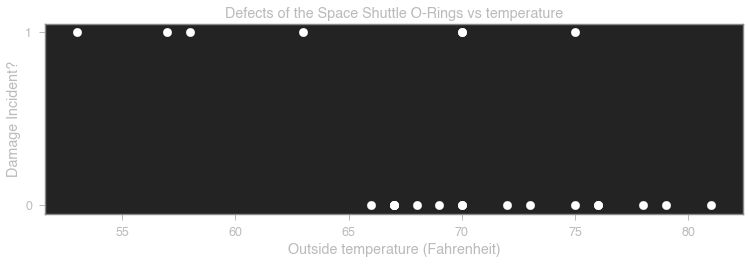

In [12]:
figsize(12.5, 3.5)

np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt('../data/challenger_data.csv', skip_header=1,
                                usecols=[1, 2], missing_values='NA', 
                                delimiter=',')
# drop the nan values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="w")
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

We need a function of temperature, call it $p(t)$, that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function.*

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t } } $$

In this model, $\beta$ is the variable we are uncertain about. Below is the function plotted for $\beta = 1, 3, -5$.

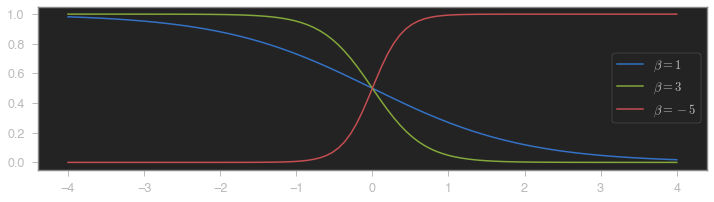

In [13]:
figsize(12, 3)


def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))


x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();

But something is missing. In the plot of the logistic function, the probability changes only near zero, but in our data above the probability changes around 65 to 70. We need to add a *bias* term to our logistic function:

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are below, with differing $\alpha$.

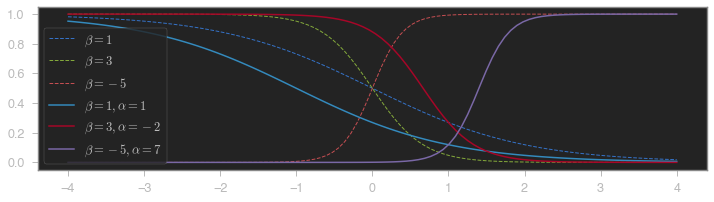

In [18]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))


x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

Adding a constant term $\alpha$ amounts to shifting the curve left or right (hence why it is called a *bias*).

Let's start modeling this in PyMC3. The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*.

In [24]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, tau=.001, testval=0)
    beta = pm.Normal('beta', mu=0, tau=.001, testval=0)
    p = pm.Deterministic('p', 1.0 / (1.0 + tt.exp(beta * temperature + alpha)))

We have our probabilities, but how do we connect them to our observed data? A *Bernoulli* random variable with parameter $p$, denoted $\text{Ber}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:

$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

where $p(t)$ is our logistic function and $t_i$ are the temperatures we have observations about. Notice in the above code we had to set the values of `beta` and `alpha` to 0. The reason for this is that if `beta` and `alpha` are very large, they make `p` equal to 1 or 0. Unfortunately, `pm.Bernoulli` does not like probabilities of exactly 0 or 1, though they are mathematically well-defined probabilities. So by setting the coefficient values to `0`, we set the variable `p` to be a reasonable starting value. This has no effect on our results, nor does it mean we are including any additional information in our prior. It is simply a computational caveat in PyMC3. 

In [25]:
with model:
    observed = pm.Bernoulli('bernoulli_obs', p, observed=D)
    
    step = pm.Metropolis()
    trace = pm.sample(120_000, step=step)
    burned_trace = trace[100_000::2]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 241000/241000 [01:39<00:00, 2427.29draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [35]:
alpha_samples = burned_trace['alpha'][:, None]  # best to make them 1D
beta_samples = burned_trace['beta'][:, None]

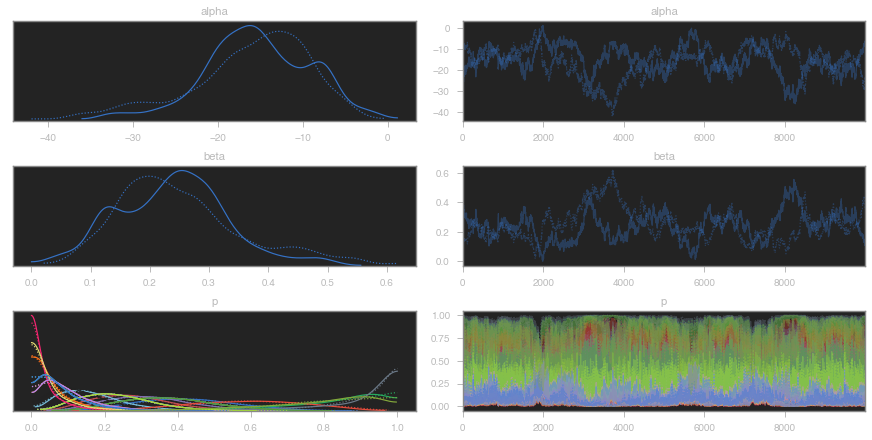

In [26]:
pm.traceplot(burned_trace);

All samples of $\beta$ are greater than 0. If instead the posterior was centered around 0, we may suspect that $\beta = 0$, implying that temperature has no effect on the probability of defect. 

Similarly, all $\alpha$ posterior values are negative and far away from 0, implying that it is correct to believe that $\alpha$ is significantly less than 0. 

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behaviour is perhaps expected).  

Next, let's look at the *expected probability* for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for $p(t_i)$.

In [41]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)
mean_prob_t = p_t.mean(axis=0)

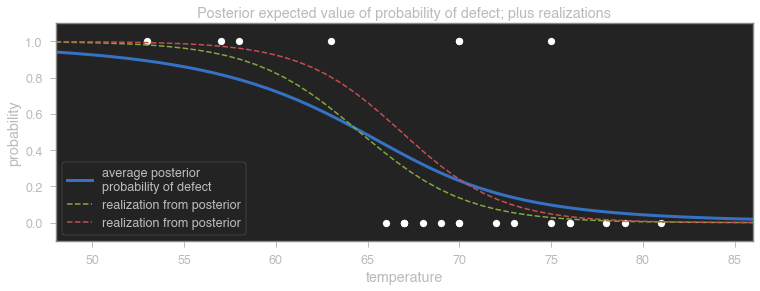

In [45]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="w", s=50)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

Above we also plotted two possible realizations of what the actual underlying system might be. Both are equally likely as any other draw. The blue line is what occurs when we average all the 20_000 possible dotted lines together.


An interesting question to ask is for what temperatures are we most uncertain about the defect-probability? Below we plot the expected value line **and** the associated 95% intervals for each temperature. 

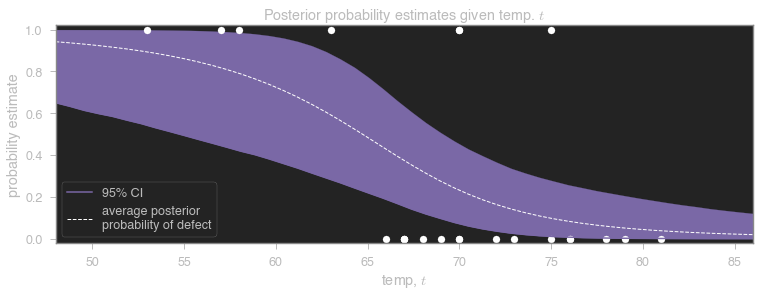

In [46]:
# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6")

plt.plot(t, mean_prob_t, lw=1, ls="--", color="w",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="w", s=50)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

The *95% credible interval*, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.75.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out over [0,1] quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.

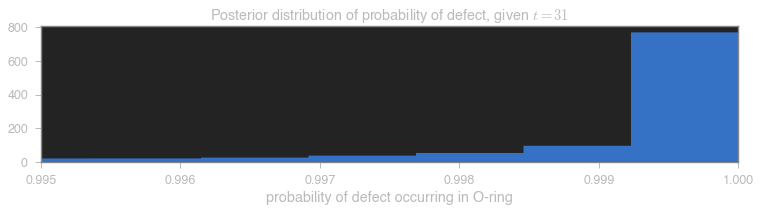

In [47]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, density=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

### Is our model appropriate?

The skeptical reader will say "You deliberately chose the logistic function for $p(t)$ and the specific priors. Perhaps other functions or priors will give different results. How do I know I have chosen a good model?" This is absolutely true. To consider an extreme situation, what if I had chosen the function $p(t) = 1,\; \forall t$, which guarantees a defect always occurring: I would have again predicted disaster on January 28th. Yet this is clearly a poorly chosen model. On the other hand, if I did choose the logistic function for $p(t)$, but specified all my priors to be very tight around 0, likely we would have very different posterior distributions. How do we know our model is an expression of the data? This encourages us to measure the model's **goodness of fit**.

We can think: *how can we test whether our model is a bad fit?* An idea is to compare observed data (which if we recall is a *fixed* stochastic variable) with artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data. 

In the current example,  we should sample from the *posterior* distributions to create *very plausible datasets*. Luckily, our Bayesian framework makes this very easy. We only need to create a new `Stochastic` variable, that is exactly the same as our variable that stored the observations, but minus the observations themselves. If you recall, our `Stochastic` variable that stored our observed data was:

    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)

Hence we create:
    
    simulated_data = pm.Bernoulli("simulation_data", p)

Let's simulate 10_000:

In [78]:
N = 10_000

with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, tau=.001, testval=0)
    alpha = pm.Normal('alpha', mu=0, tau=.001, testval=0)
    p = pm.Deterministic('p', 1.0 / (1. + tt.exp(beta * temperature + alpha)))
    observed = pm.Bernoulli('bernoulli_obs', p, observed=D)
    
    simulated = pm.Bernoulli('bernoulli_sim', p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_sim]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:26<00:00, 798.61draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Simulated dataset using posterior parameters


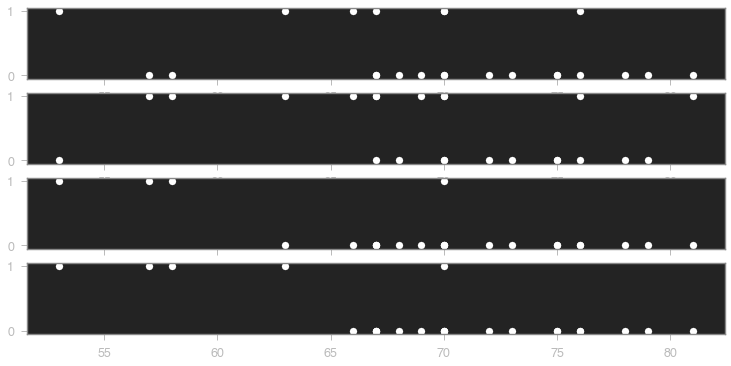

In [79]:
figsize(12.5, 5)

simulations = trace["bernoulli_sim"]
print("Simulated dataset using posterior parameters")

figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], 
                color="w", s=50)

We wish to assess how good our model is. "Good" is a subjective term of course, so results must be relative to other models. 

We will be doing this graphically as well, which may seem like an even less objective method. Gelman emphasises that the graphical tests are more illuminating than p-value tests.

The following graphical test is a novel data-viz approach to logistic regression. The plots are called *separation plots*. For a suite of models we wish to compare, each model is plotted on an individual separation plot.

For each model, we calculate the proportion of times the posterior simulation proposed a value of 1 for a particular temperature, i.e. compute $P( \;\text{Defect} = 1 | t, \alpha, \beta )$ by averaging. This gives us the posterior probability of a defect at each data point in our dataset. For example, for the model we used above:

In [81]:
posterior_probability = simulations.mean(axis=0)
print("posterior prob of defect | realized defect ")
for i in range(len(D)):
    print(f'{posterior_probability[i]:.2f}                     |    {D[i]}')

posterior prob of defect | realized defect 
0.43                     |    0.0
0.23                     |    1.0
0.27                     |    0.0
0.31                     |    0.0
0.38                     |    0.0
0.16                     |    0.0
0.13                     |    0.0
0.23                     |    0.0
0.81                     |    1.0
0.60                     |    1.0
0.22                     |    1.0
0.07                     |    0.0
0.37                     |    0.0
0.87                     |    1.0
0.37                     |    0.0
0.10                     |    0.0
0.23                     |    0.0
0.05                     |    0.0
0.08                     |    0.0
0.06                     |    0.0
0.10                     |    1.0
0.09                     |    0.0
0.79                     |    1.0


In [90]:
ix = np.argsort(posterior_probability)
print('prob | defect')
for i in range(len(D)):
    print(f'{posterior_probability[ix[i]]:.2f} |   {D[ix[i]]}')

prob | defect
0.05 |   0.0
0.06 |   0.0
0.07 |   0.0
0.08 |   0.0
0.09 |   0.0
0.10 |   0.0
0.10 |   1.0
0.13 |   0.0
0.16 |   0.0
0.22 |   1.0
0.23 |   1.0
0.23 |   0.0
0.23 |   0.0
0.27 |   0.0
0.31 |   0.0
0.37 |   0.0
0.37 |   0.0
0.38 |   0.0
0.43 |   0.0
0.60 |   1.0
0.79 |   1.0
0.81 |   1.0
0.87 |   1.0


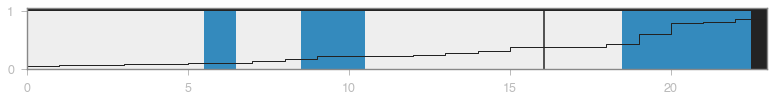

In [95]:
figsize(11., 1.5)
separation_plot(posterior_probability, D)

The snaking-line is the sorted probabilities, blue bars denote defects, and empty space denote non-defects.  As the probability rises, we see more and more defects occur. On the right hand side, the plot suggests that as the posterior probability is large (line close to 1), then more defects are realized. This is good behaviour. Ideally, all the blue bars *should* be close to the right-hand side, and deviations from this reflect missed predictions. 

The black vertical line is the expected number of defects we should observe, given this model. This allows the user to see how the total number of events predicted by the model compares to the actual number of events in the data.

It is much more informative to compare this to separation plots for other models. Below we compare our model (top) versus three others:

1. the perfect model, which predicts the posterior probability to be equal 1 if a defect did occur.
2. a completely random model, which predicts random probabilities regardless of temperature.
3. a constant model:  where $P(D = 1 \; | \; t) = c, \;\; \forall t$. The best choice for $c$ is the observed frequency of defects, in this case 7/23.

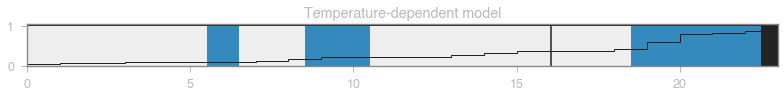

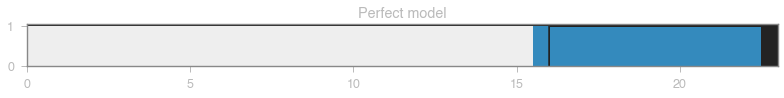

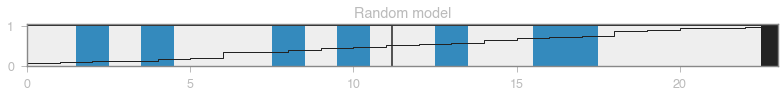

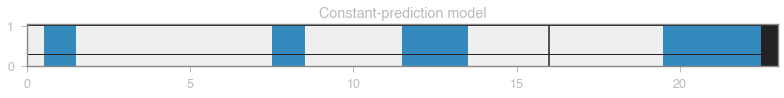

In [96]:
figsize(11., 1.25)

separation_plot(posterior_probability, D)
plt.title("Temperature-dependent model")

p = D
separation_plot(p, D)
plt.title("Perfect model")

p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

constant_prob = 7./23*np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model");

In the random model, we can see that as the probability increases there is no clustering of defects to the right-hand side. Similarly for the constant model.

The perfect model, the probability line is not well shown, as it is stuck to the bottom and top of the figure.

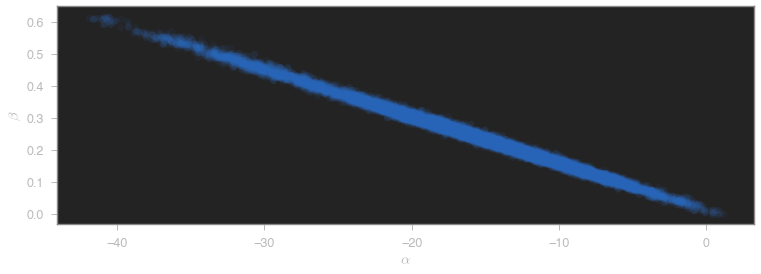

In [107]:
figsize(12.5, 4)
plt.scatter(alpha_samples, beta_samples, alpha=.069)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");